# U-NET example

Example of U-NET module using tensorflow 2. The example uses the unet packages cloned from https://github.com/jakeret/unet

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import unet
from unet import utils
from unet.datasets import circles
from copy import deepcopy
from sklearn.metrics import confusion_matrix

import inspect

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.3.0
GPU is NOT AVAILABLE


## Auxiliary functions

In [2]:
def read_data(fname):
    """
    Reads features and labels stored in npz files
    
    Parameters
    ----------
    fname : str
        path of the file containing the data
        
    Returns
    -------
    X : float array 
        features matrix of size nx, ny, nchannels
    y : float array
        lables matrix of size, nx, ny, nclasses
    
    """
    with np.load(fname, allow_pickle=False) as npz_file:
        # Load the arrays
        X = npz_file['features']
        y = npz_file['targets']
    return X, y

In [3]:
def data_generator(file_list, stop_at_end=False):
    """
    data generator
    
    Parameters
    ----------
    file_list : list of str
        lists of files where the data is stored
    stop_at_end : bool
        Controls the behaviour when running out of files.
        If True exits the function. Otherwise reshuffles the list
        and sets the counter to 0
    
    Yield
    -------
    X : float array 
        features matrix of size nx, ny, nchannels
    y : float array
        lables matrix of size, nx, ny, nclasses
    
    """
    i = 0
    while True:
        if i >= len(file_list):
            if stop_at_end:
                break
            i = 0
            np.random.shuffle(file_list)            
        else:
            X, y = read_data(file_list[i])            
            yield X, y
            i = i + 1

In [4]:
def get_dataset(flist, stop_at_end=False):
    """
    Creates a tensorflow dataset from a generator
    
    Parameters
    ----------
    file_list : list of str
        lists of files where the data is stored
    stop_at_end : bool
        Controls the behaviour when running out of files.
        If True exits the function. Otherwise reshuffles the list
        and sets the counter to 0
    
    Returns
    -------
    dataset : tf.data.Dataset
        A dataset containing the features and labels
    
    """
    X, y = read_data(flist[0])
    nx = X.shape[0]
    ny = X.shape[1]
    nchannels = X.shape[2]
    nclasses = y.shape[2]
    return tf.data.Dataset.from_generator(
        data_generator, args=[flist, stop_at_end], output_types=(tf.float32, tf.float32),
        output_shapes = ((nx, ny, nchannels), (nx, ny, nclasses)))

In [5]:
def examine_data(flist):
    """
    Get the number of pixels corresponding to each class and the total number
    of pixels in a dataset
    
    Parameters
    ----------
    flist : list of str
        lists of files where the data is stored
    
    Returns
    -------
    total : int
        The total number of pixels in the dataset
    nel_class : array of ints
        The number of pixels for each class
    
    """
    _, y = read_data(flist[0])    
    nclasses = y.shape[2]
                 
    total = 0
    nel_class = np.zeros(nclasses, dtype=np.int)
    for i, fname in enumerate(flist):
        _, y = read_data(fname)
        total += int(y.size/nclasses)
        
        for j in range (nclasses):
            ind = np.where(y[:, :, j] == 1)[0]
            nel_class[j] += ind.size
    return total, nel_class

In [6]:
def weighted_binary_crossentropy(zero_weight, one_weight):
    """
    Computes the weighted binary crossentropy
    
    Parameters
    ----------
    zero_weight, one_weight : float
        The weights for each class
    
    Returns
    -------
    weigthed_bce : tensor flow array
        The weighted loss at each pixel
    
    """
    def wbce(y_true, y_pred):
        # Calculate binary crossentropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        ## Apply weights
        index = tf.cast(tf.argmax(y_true, axis=-1), tf.float32) # from one hot to indices
        weight_vector = index*one_weight+(1.-index)*zero_weight
        weigthed_bce = weight_vector*bce
        
        return weigthed_bce
    return wbce

## Load data

In [7]:
flist = glob.glob('/data/ml_course/05_Capstone_project/dl_data/*_data.npz')
flist.sort()
np.random.shuffle(flist)
print('Number of input files:', len(flist))

Number of input files: 4351


In [8]:
nfiles_te = 4
nfiles_va = 4
nfiles_tr = 36

flist_te = flist[0:nfiles_te]
flist_va = flist[nfiles_te:nfiles_te+nfiles_va]
flist_tr = flist[nfiles_te+nfiles_va:nfiles_te+nfiles_va+nfiles_tr]

print('Number of test files:', len(flist_te))
print('Number of validation files:', len(flist_va))
print('Number of training files:', len(flist_tr))

Number of test files: 4
Number of validation files: 4
Number of training files: 36


In [9]:
train_dataset = get_dataset(flist_tr, stop_at_end=False)
validation_dataset = get_dataset(flist_va, stop_at_end=False)
test_dataset = get_dataset(flist_te, stop_at_end=True) # Put to stop at end because there is no stopping mechanism in the u-net evaluation

## Compute class weights

In [10]:
total, nel_class = examine_data(flist_tr)
print('Total number of pixels in training dataset:', total)
print('Number of no hail pixels:', nel_class[0])
print('Number of hail pixels:', nel_class[1])
print('% o hail pixels over total:', 100*nel_class[1]/total)

Total number of pixels in training dataset: 4128768
Number of no hail pixels: 4125321
Number of hail pixels: 3447
% o hail pixels over total: 0.08348737444196429


In [11]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_nohail = (1 / nel_class[0])*(total)/2.0 
weight_hail = (1 / nel_class[1])*(total)/2.0

class_weight = {0: weight_nohail, 1: weight_hail}

print('Weight for no hail: {:.2f}'.format(weight_nohail))
print('Weight for hail: {:.2f}'.format(weight_hail))

Weight for no hail: 0.50
Weight for hail: 598.89


## Create model

In [12]:
unet_model = unet.build_model(channels=3,
                              num_classes=2,
                              layer_depth=3,
                              filters_root=16)

In [13]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5),
    tf.keras.metrics.FalseNegatives(name='fn', thresholds=0.5),
    tf.keras.metrics.FalsePositives(name='fp', thresholds=0.5),
    tf.keras.metrics.TrueNegatives(name='tn', thresholds=0.5),
    tf.keras.metrics.TruePositives(name='tp', thresholds=0.5)
]

loss = weighted_binary_crossentropy(weight_nohail, weight_hail)
# loss = tf.keras.losses.BinaryCrossentropy()

unet.finalize_model(
    unet_model, loss=loss,
    metrics=metrics,
    dice_coefficient=True,
    auc=False,
    mean_iou=False)

## Train model

In [14]:
epochs = 3
batch_size = 4
fit_kwargs = {
    'steps_per_epoch': int(nfiles_tr/batch_size),
    'validation_steps': int(nfiles_va/batch_size)}

trainer = unet.Trainer(name='MSG_unet', log_dir_path='./callbacks/', checkpoint_callback=False)
history = trainer.fit(unet_model,
            train_dataset,
            validation_dataset,
            epochs=epochs,
            batch_size=batch_size,
            **fit_kwargs)

Epoch 1/3
1/9 [==>...........................] - ETA: 0s - loss: 0.5084 - binary_accuracy: 0.2887 - fn: 276155.0000 - fp: 225318.0000 - tn: 127194.0000 - tp: 76357.0000 - dice_coefficient: 0.4664WARNING:tensorflow:From /opt/anaconda3/envs/exts-ml2/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
9/9 [==============================] - 14s 2s/step - loss: 0.7025 - binary_accuracy: 0.4132 - fn: 2179678.0000 - fp: 1543498.0000 - tn: 1629110.0000 - tp: 992930.0000 - dice_coefficient: 0.4884 - val_loss: 0.6596 - val_binary_accuracy: 0.4456 - val_fn: 232620.0000 - val_fp: 158245.0000 - val_tn: 194267.0000 - val_tp: 119892.0000 - val_dice_coefficient: 0.4984 - learning_rate: 0.0010
Epoch 2/3
9/9 [==============================] - 12s 1s/step - loss: 0.6870 - binary_accuracy: 0.3645 - fn: 2387022.0000 - 

In [15]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'fn', 'fp', 'tn', 'tp', 'dice_coefficient', 'val_loss', 'val_binary_accuracy', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_dice_coefficient', 'learning_rate'])

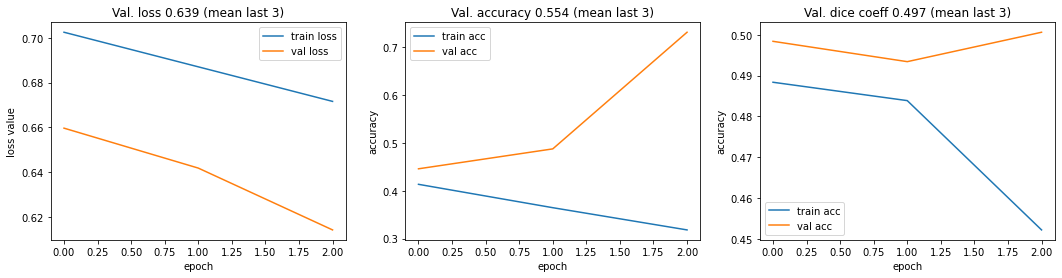

In [16]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Val. loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['binary_accuracy'], label='train acc')
ax2.plot(history.history['val_binary_accuracy'], label='val acc')
ax2.set_title('Val. accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_binary_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

# Plot accuracy values
ax3.plot(history.history['dice_coefficient'], label='train acc')
ax3.plot(history.history['val_dice_coefficient'], label='val acc')
ax3.set_title('Val. dice coeff {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_dice_coefficient'][-3:]) # last three values
))
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend()

plt.show()

## Save trained model

In [17]:
unet_model.save('./saved_models')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_models/assets


## Make predictions

In [18]:
pred_batch_size = 4
prediction = unet_model.predict(test_dataset.batch(pred_batch_size), verbose=1, steps=int(nfiles_te/pred_batch_size))

1/1 [==============================] - 0s 3ms/step


In [19]:
dataset = test_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

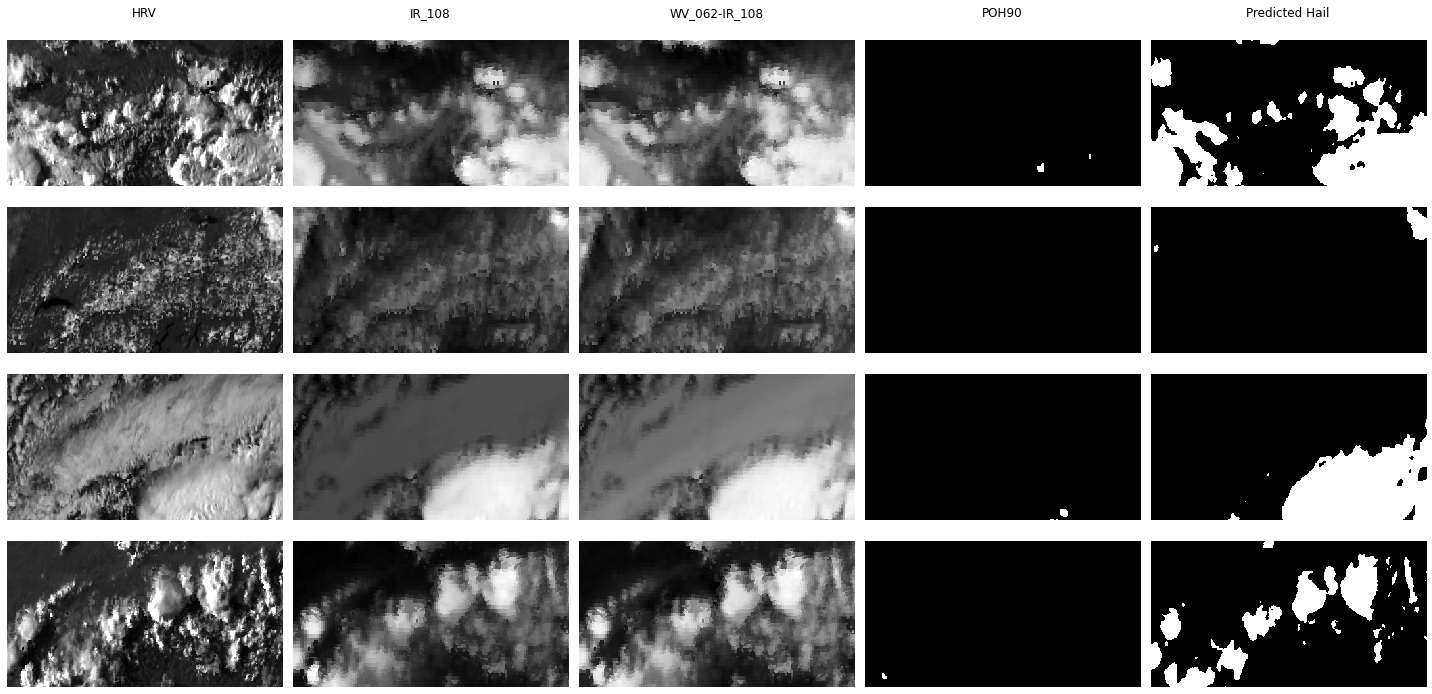

In [20]:
fig, ax = plt.subplots(4, 5, figsize=(20,10))
for i, (image, label) in enumerate(dataset.take(4)):
    hrv = image.numpy()[:, :, 0]
    ir = image.numpy()[:, :, 1]
    diff = image.numpy()[:, :, 2]
    
    lab = np.argmax(label, axis=-1)
    pred = np.argmax(prediction[i,...], axis=-1)
        
    ax[i][0].matshow(hrv.T[::-1, :], cmap=plt.cm.gray)
    ax[i][0].axis('off')
    ax[0][0].set_title('HRV')
    
    ax[i][1].matshow(ir.T[::-1, :], cmap=plt.cm.gray_r)
    ax[i][1].axis('off')
    ax[0][1].set_title('IR_108')
    
    ax[i][2].matshow(diff.T[::-1, :], cmap=plt.cm.gray)
    ax[i][2].axis('off')
    ax[0][2].set_title('WV_062-IR_108')
    
    ax[i][3].matshow(lab.T[::-1, :], cmap=plt.cm.gray)
    ax[i][3].axis('off')
    ax[0][3].set_title('POH90')
    
    ax[i][4].matshow(pred.T[::-1, :], cmap=plt.cm.gray)
    ax[i][4].axis('off')
    ax[0][4].set_title('Predicted Hail')
    
plt.tight_layout()

## Evaluate model

In [21]:
tn = 0
fp = 0
fn = 0
tp = 0

positive = 0
negative = 0
for i, (image, label) in enumerate(dataset.take(-1)):
    lab = np.argmax(label, axis=-1)
    pred = np.argmax(prediction[i,...], axis=-1)
    
    tn_aux, fp_aux, fn_aux, tp_aux = confusion_matrix(lab.flatten(), pred.flatten()).ravel()
    
    tn += tn_aux
    fp += fp_aux
    fn += fn_aux
    tp += tp_aux
    
    positive += lab[lab == 1].size
    negative += lab[lab == 0].size
    
print('True positive: ', tp)
print('True negative: ', tn)
print('False positive: ', fp)
print('False negative: ', fn)
print('Positive pixels: ', positive)
print('Negative pixels: ', negative)

True positive:  311
True negative:  289667
False positive:  62534
False negative:  0
Positive pixels:  311
Negative pixels:  352201


In [22]:
pod = 100*tp/(tp+fn)
far = 100*fp/(fp+tn)
ppv = tp/(tp+fp)
print('Probability of Detection (POD):', pod)
print('False Alarm Rate (FAR):', far)
print('Positive Predictive Value (PPV):', ppv)

Probability of Detection (POD): 100.0
False Alarm Rate (FAR): 17.755202285058814
Positive Predictive Value (PPV): 0.0049486832683586605


In [23]:
## This is not working properly
# trainer.evaluate(unet_model, test_dataset, shape=prediction.shape[1:])

In [24]:
## This is not working properly
# X, y = read_data(flist_te[0])
# 
# X = utils.crop_to_shape(X, prediction.shape[1:])
# y = utils.crop_to_shape(y, prediction.shape[1:])
# 
# X = X[np.newaxis, :, :, :]
# y = y[np.newaxis, :, :, :]
# 
# unet_model.evaluate(x=(X, y), batch_size=1, verbose=1, return_dict=True)